In [38]:
from statistics import mean, median

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


In [39]:
# sns paper style
sns.set_theme(context="paper", style="whitegrid", font_scale=2.0)


## Helper functions

In [40]:
def add_percentage_labels(plot, feature):
    total = len(feature)
    percentatges = [f'{100 * p.get_height()/total:.1f}%' for p in plot.patches]
    plot.bar_label(plot.containers[0], labels=percentatges, rotation=30)


## Exploration

In [41]:
data_dump_path = "../data/data_dump_14_04_23"
annotations_df = pd.read_pickle(f"{data_dump_path}/annotations.pickle")
evaluations_df = pd.read_pickle(f"{data_dump_path}/evaluations.pickle")
skippedtracks_df = pd.read_pickle(f"{data_dump_path}/skippedtracks.pickle")
users_df = pd.read_pickle(f"{data_dump_path}/users.pickle")


### Users

#### Code

In [42]:
AGREEMENT_OPTIONS = {
    0: "Completely Disagree",
    1: "Strongly Disagree",
    2: "Disagree",
    3: "Neither Agree nor Disagree",
    4: "Agree",
    5: "Strongly Agree",
    6: "Completely Agree",
}

AGE_GROUPS = {
    -1: "",
    0: "18-24",
    1: "25-34",
    2: "35-44",
    3: "45-54",
    4: "55-64",
    5: "65+",
}

ENGLISH_OPTIONS = {
    0: "Yes",
    1: "More or less",
    2: "No",
}


In [43]:
users_display = users_df.copy()
users_display["age_group"] = users_df["age_group"].apply(lambda x: AGE_GROUPS[x])
users_display["english_level"] = users_df["english_level"].apply(lambda x: ENGLISH_OPTIONS[x])
users_display.drop(["created"], axis=1, inplace=True)
users_display["has_annotations"] = users_display.index.isin(annotations_df["user_id"])
users_display["has_evaluations"] = users_display.index.isin(evaluations_df["user_id"])
# users_display.head()


In [44]:
def user_report(user_df, cols=None):
    if cols is None:
        cols = ["age_group", "english_level", "country", "music_doing", "music_writing", "music_reading"]
    for col in cols:
        figsize = figsize=(5, 4)
        order=None
        if col == "english_level":
            title = "Are you comfortable writing in English?"
        elif col == "age_group":
            title = "How old are you?"
            order = [age_label for age_label in AGE_GROUPS.values() if age_label]
        elif col == "country":
            figsize = figsize=(20, 5)
            order = user_df[col].value_counts().index
            title = "Where do you live?"
        elif col == "music_doing":
            title = "I spend a lot of my free time doing music-related activities"
        elif col == "music_writing":
            title = "I enjoy writing about music, for example on blogs or social media"
        elif col == "music_reading":
            title = "I often read or search the internet for things related to music"
        plt.figure(figsize=figsize)
        plot = sns.countplot(x=col, data=user_df, order=order)
        plot.set_title(title)
        # add_percentage_labels(plot, user_df[col])


In [45]:
evaluations_per_user = evaluations_df.join(users_df, on="user_id").groupby("user_id").count().iloc[:, 0].sort_values(ascending=False).values
annotations_per_user = annotations_df.join(users_df, on="user_id").groupby("user_id").count().iloc[:, 0].sort_values(ascending=False).values


#### Report

Some basic stats about _**all**_ the users:

In [46]:
def user_stats(user_df):
    evaluations_per_user = evaluations_df.join(user_df, on="user_id").groupby("user_id").count().iloc[:, 0].mean()
    annotations_per_user = annotations_df.join(user_df, on="user_id").groupby("user_id").count().iloc[:, 0].mean()
    return {
    "Number of users": len(user_df),
    "Average number of annotations per users": round(annotations_per_user, 2),
    "Average number of evaluations per users": round(evaluations_per_user, 2),
}


{'Number of users': 337, 'Average number of annotations per users': 7.79, 'Average number of evaluations per users': 7.73}


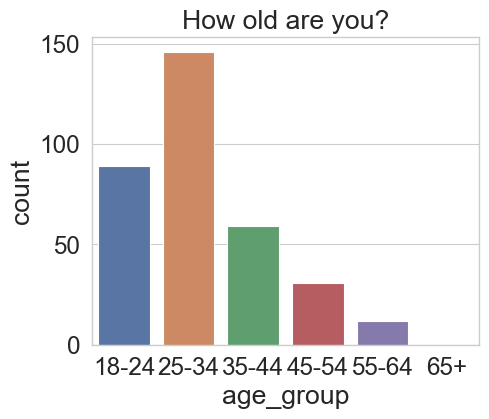

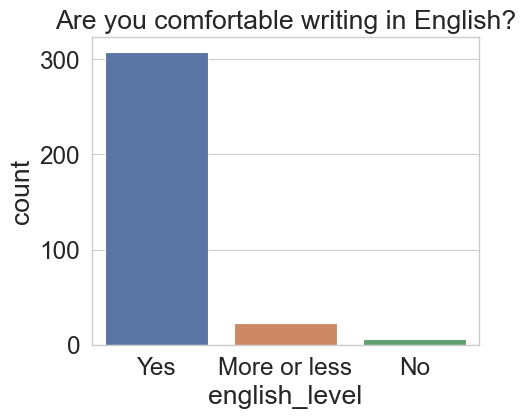

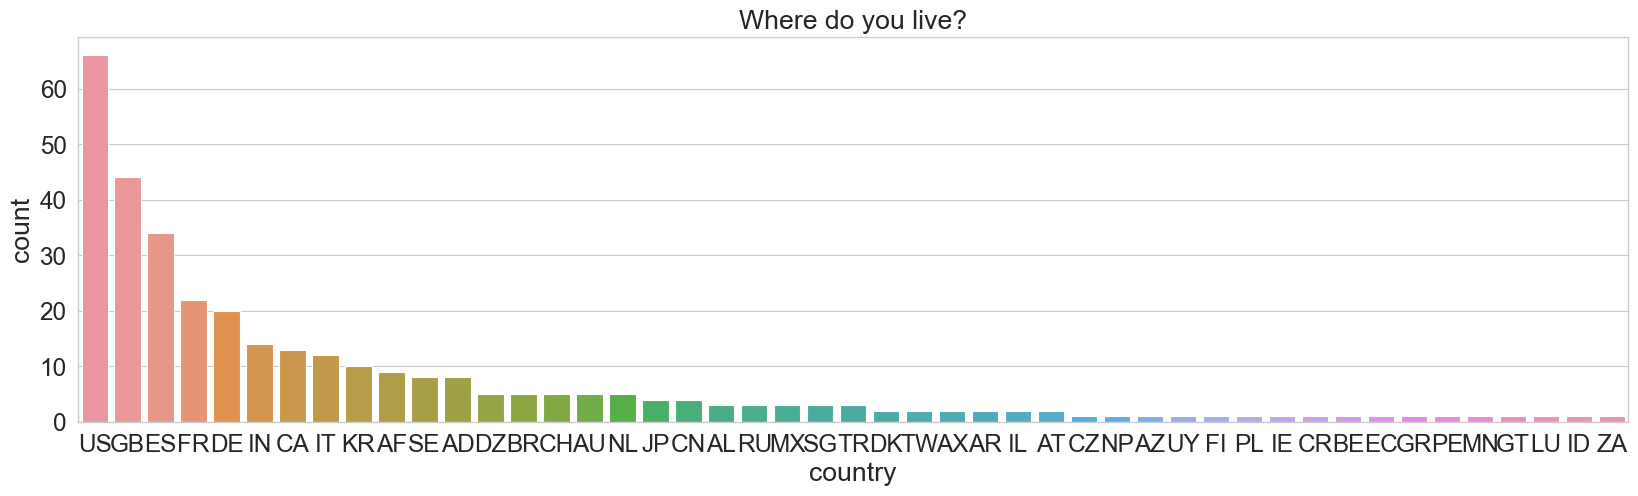

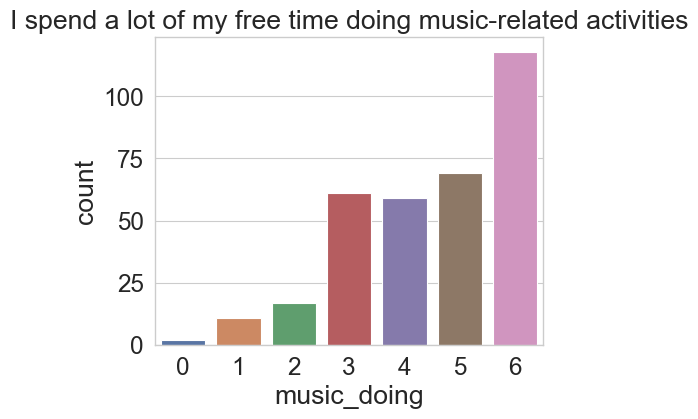

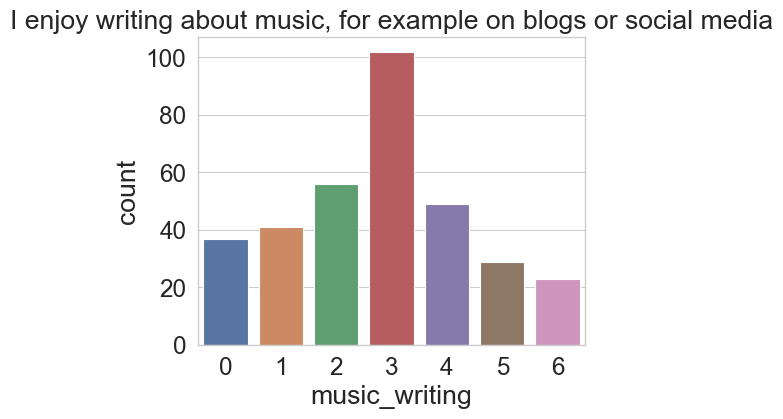

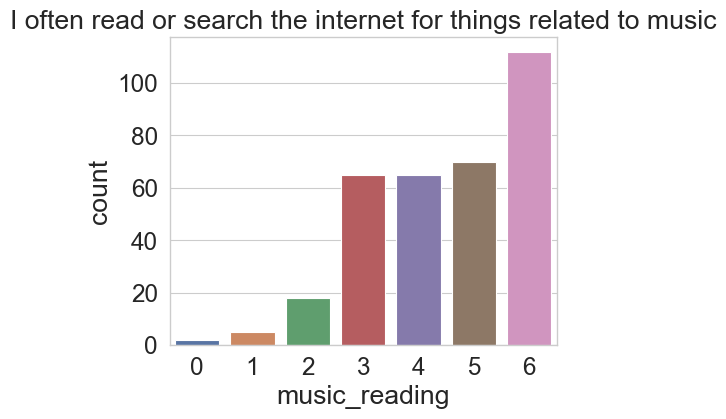

In [47]:
print(user_stats(users_display))
user_report(users_display)


Some basic stats about _**active**_ the users:

{'Number of users': 142, 'Average number of annotations per users': 7.79, 'Average number of evaluations per users': 7.73}


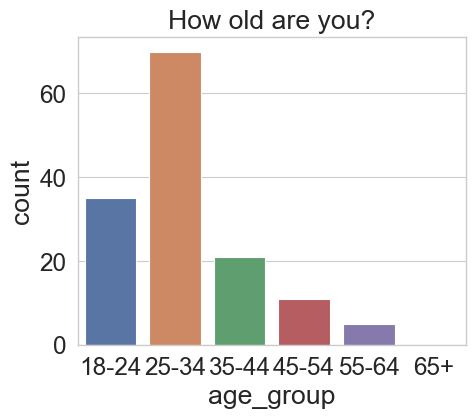

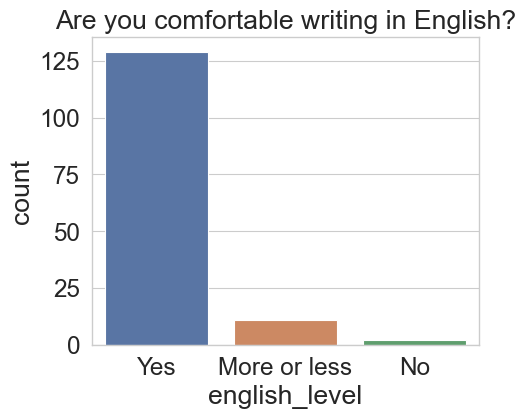

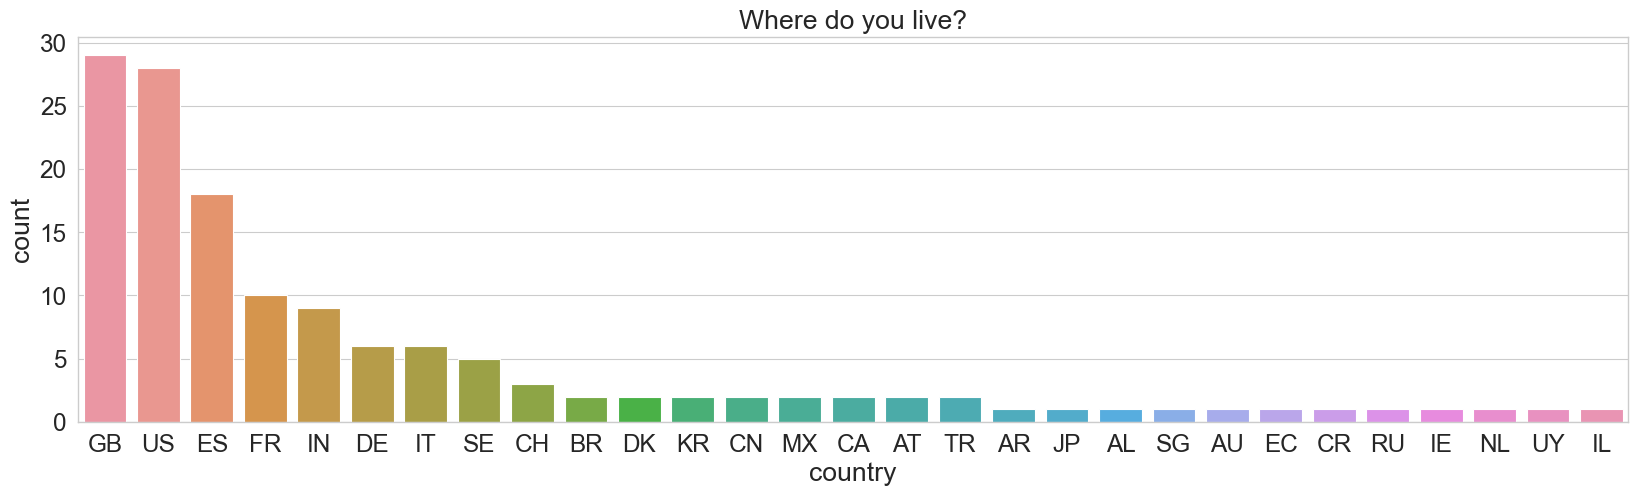

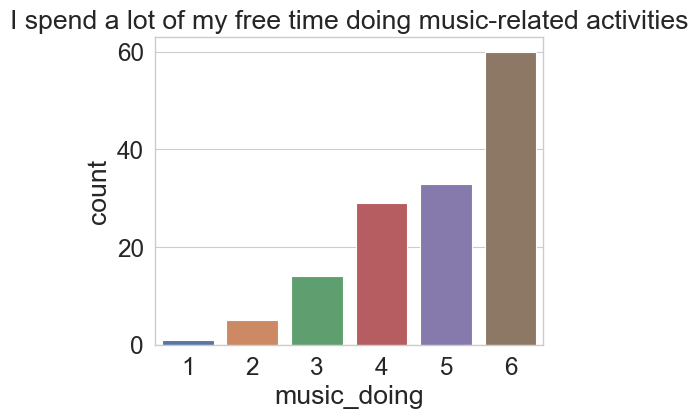

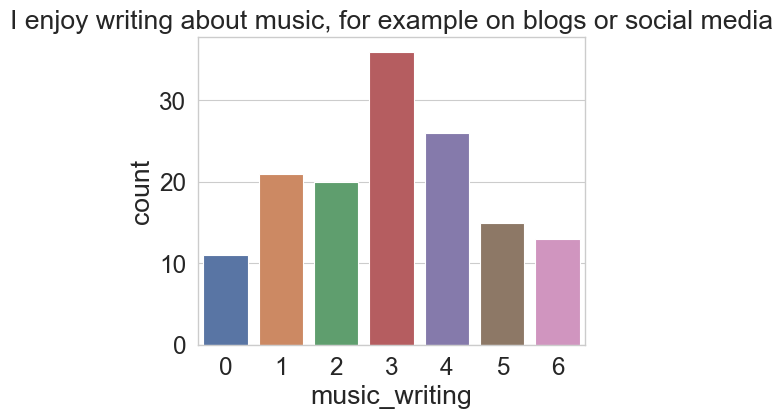

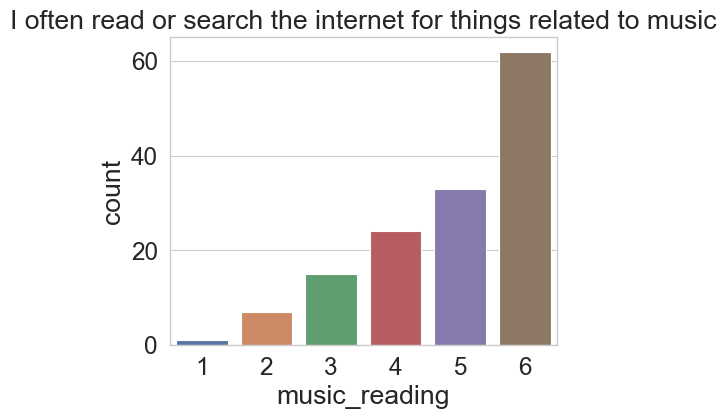

In [48]:
users_display_active = users_display[users_display["has_annotations"]]
print(user_stats(users_display_active))
user_report(users_display_active)


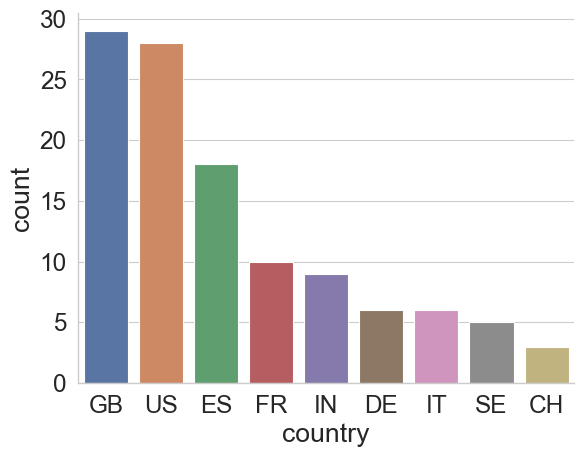

In [68]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return "{v:d}".format(v=val)
    return my_autopct

country_counts = users_display_active["country"].value_counts()
cut_off_country = 3
country_counts = country_counts[country_counts >= cut_off_country]
df_to_plot = users_display_active[users_display_active["country"].isin(country_counts.index)]
order = country_counts.sort_values(ascending=False).index
plot = sns.countplot(x="country", data=users_display_active, order=order)
sns.despine()


Text(0.5, 1.0, 'Average rating received per user')

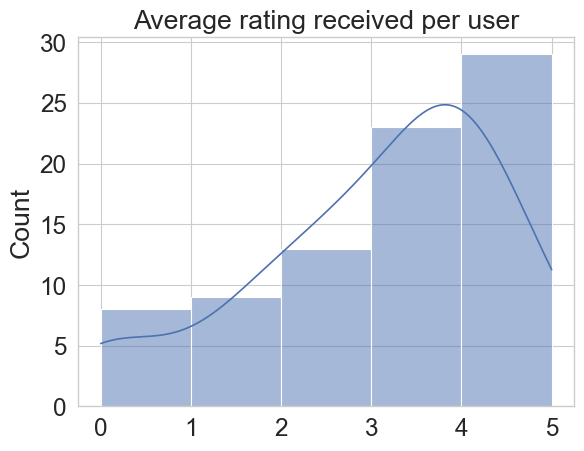

In [69]:
ratings_per_annotation_user = annotations_df.merge(evaluations_df, left_on='id', right_on='annotation_id').groupby('user_id_x')['rating'].mean().sort_values(ascending=False).values
sns.histplot(ratings_per_annotation_user, kde=True, bins=5).set_title("Average rating received per user")


Text(0.5, 1.0, 'Average rating given per user')

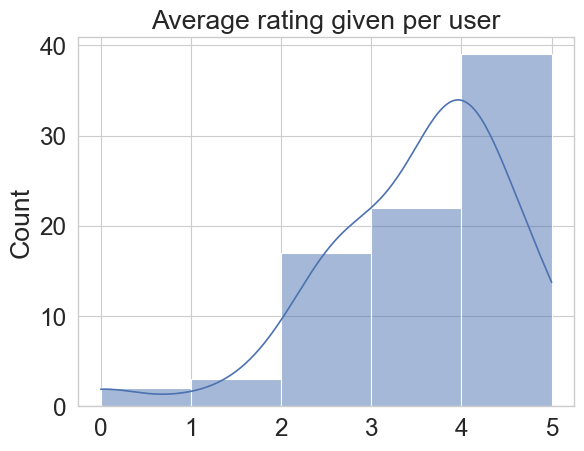

In [70]:
ratings_per_evaluation_user = evaluations_df.groupby('user_id')['rating'].mean().sort_values(ascending=False).values
sns.histplot(ratings_per_evaluation_user, kde=True, bins=5).set_title("Average rating given per user")


Text(0, 0.5, '% of users')

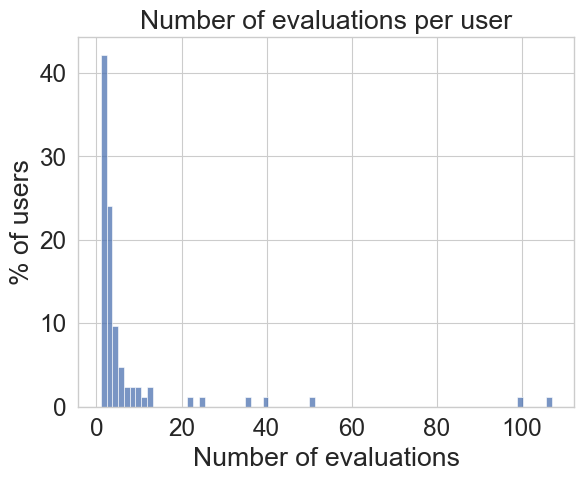

In [71]:
evaluations_per_user = evaluations_df.join(users_df, on="user_id").groupby("user_id").count().iloc[:, 0].sort_values(ascending=False).values
sns.histplot(evaluations_per_user, stat='percent').set_title("Number of evaluations per user")
plt.xlabel("Number of evaluations")
plt.ylabel("% of users")


Text(0, 0.5, '% of users')

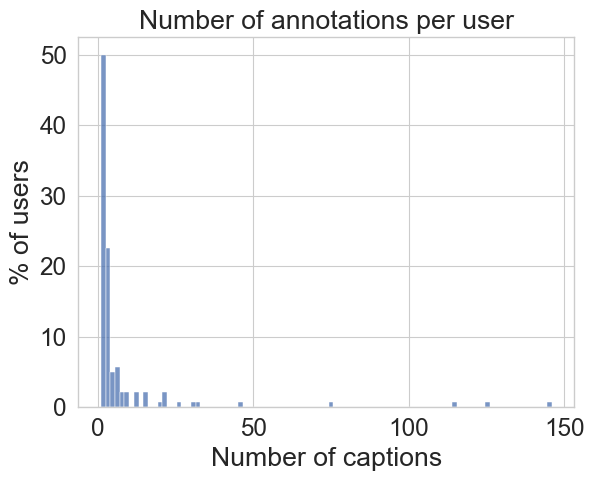

In [72]:
annotations_per_user = annotations_df.join(users_df, on="user_id").groupby("user_id").count().iloc[:, 0].sort_values(ascending=False).values
sns.histplot(annotations_per_user, stat='percent').set_title("Number of annotations per user")
plt.xlabel("Number of captions")
plt.ylabel("% of users")


### Annotations

#### Code

In [73]:
annotations_display_df = annotations_df.copy()
annotations_display_df.drop(["timestamp"], axis=1, inplace=True)


#### Report

Did users leave any comments?

In [74]:
annotations_display_df[annotations_display_df['comments'] != ''] 


,familiarity,text,track_id,comments,user_id
id,,,,,
750,0,"happy solo piano, could be used for commercial...",1124837,its not the full piece,da3ec3c82b733532aff2725a62226c1a7ac60d1504ea2b...


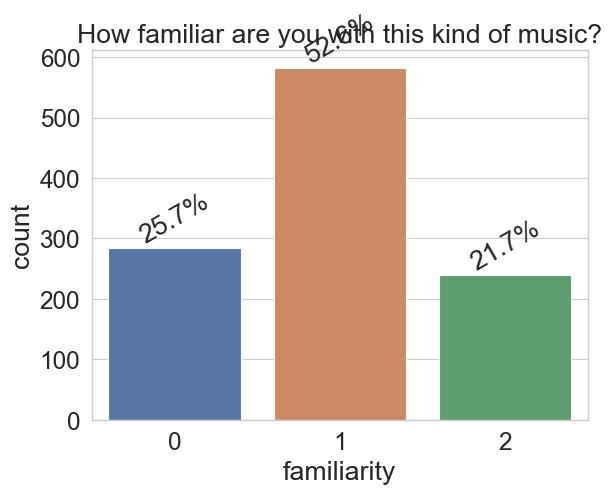

In [75]:
plot = sns.countplot(x='familiarity', data=annotations_display_df)
plot.set_title("How familiar are you with this kind of music?")
add_percentage_labels(plot, annotations_display_df['familiarity'])


In [76]:
annotations_per_track = annotations_display_df.join(users_df, on="user_id").groupby("track_id").count().sort_values("user_id", ascending=False)["user_id"].values.tolist()
evaluations_per_track = annotations_display_df.merge(evaluations_df, left_on=['id'], right_on=['annotation_id'], how='outer').groupby('track_id').agg({'annotation_id': 'count'}).fillna(0)['annotation_id'].sort_values(ascending=True).values.tolist()
evaluations_per_caption = annotations_display_df.merge(evaluations_df, left_on=['id'], right_on=['annotation_id']).groupby('annotation_id').count()['comments'].sort_values(ascending=False).values.tolist()


Number of captions:  1106


Text(0.5, 1.0, 'Number of evaluations per caption')

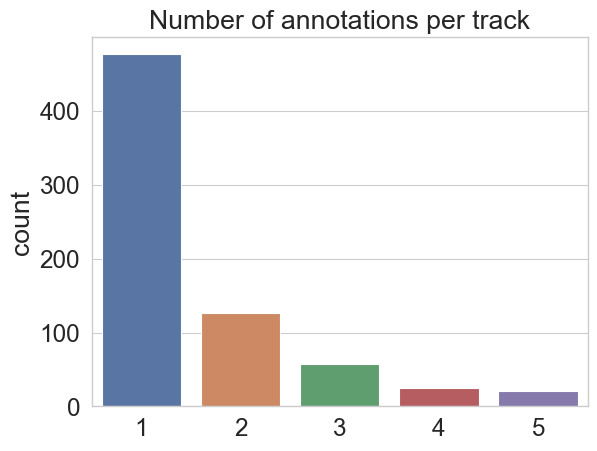

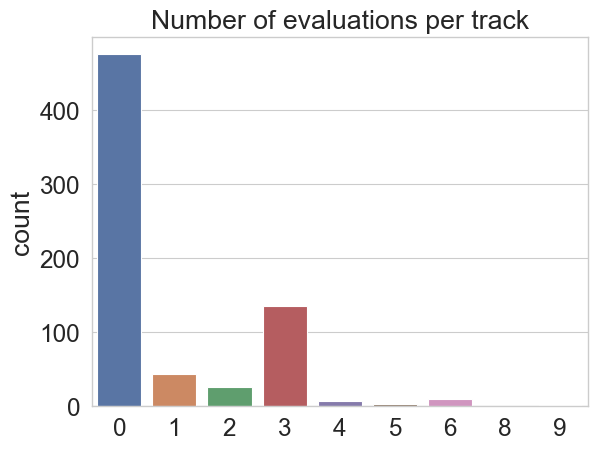

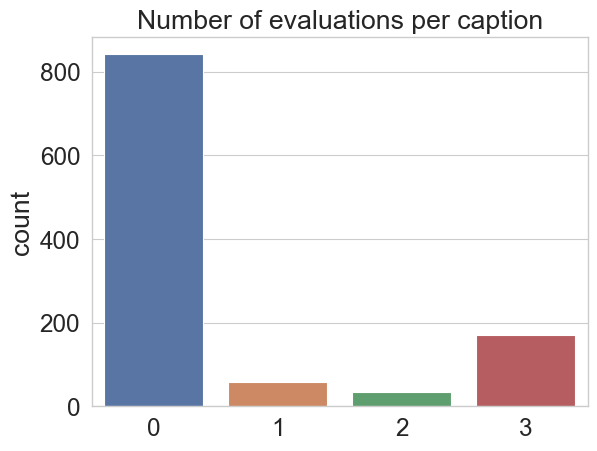

In [77]:
print("Number of captions: ", len(annotations_df))

evaluations_per_caption.extend([0] * (len(annotations_df) - evaluations_df['annotation_id'].nunique()))

plt.figure()
sns.countplot(x=annotations_per_track).set_title("Number of annotations per track")
plt.figure()
sns.countplot(x=evaluations_per_track).set_title("Number of evaluations per track")
plt.figure()
sns.countplot(x=evaluations_per_caption).set_title("Number of evaluations per caption")


### Caption Analysis

In [78]:
from collections import Counter
from typing import List

from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

def caption_stats(captions: List[str]):
    vocab = Counter()
    tokenized_captions = [word_tokenize(caption) for caption in captions]
    #drop punctuation
    tokenized_captions = [[word for word in caption if word.isalnum()] for caption in tokenized_captions]
    lengths = [len(caption) for caption in tokenized_captions]
    print(f"Caption length: Mean {mean(lengths):.02f}, Median {median(lengths)}, Min {min(lengths)}, Max {max(lengths)}")
    # TODO
    # unique_words
    vocab.update([word.lower() for caption in tokenized_captions for word in caption])
    print(f"Number of words: {sum(vocab.values())}")
    print(f"Number of unique words: {len(vocab)}")
    print(f"Most common words: {vocab.most_common(10)}")
    # drop stopwords
    stop_words = set(stopwords.words('english'))
    vocab_sw = vocab.copy()
    for word in stop_words:
        del vocab_sw[word]
    print(f"Number of words (no stopwords): {sum(vocab_sw.values())}")
    print(f"Number of unique words (no stopwords): {len(vocab_sw)}")
    print(f"Most common words (no stopwords): {vocab_sw.most_common(10)}")

captions = annotations_df['text'].values.tolist()
first_sentences = [sent_tokenize(caption)[0] for caption in captions]
print("Caption stats")
caption_stats(captions)
print()
print("First sentence stats")
caption_stats(first_sentences)


Caption stats
Caption length: Mean 19.49, Median 16.0, Min 6, Max 99
Number of words: 21555
Number of unique words: 2625
Most common words: [('a', 1570), ('and', 1094), ('with', 827), ('the', 661), ('song', 572), ('of', 346), ('in', 315), ('guitar', 315), ('an', 278), ('is', 266)]
Number of words (no stopwords): 13254
Number of unique words (no stopwords): 2517
Most common words (no stopwords): [('song', 572), ('guitar', 315), ('track', 265), ('male', 215), ('piano', 205), ('rock', 159), ('music', 156), ('vocals', 149), ('instrumental', 139), ('voice', 132)]

First sentence stats
Caption length: Mean 16.01, Median 14.0, Min 3, Max 63
Number of words: 17707
Number of unique words: 2282
Most common words: [('a', 1328), ('and', 912), ('with', 747), ('song', 505), ('the', 387), ('guitar', 285), ('of', 277), ('in', 246), ('that', 245), ('an', 242)]
Number of words (no stopwords): 11086
Number of unique words (no stopwords): 2182
Most common words (no stopwords): [('song', 505), ('guitar', 2

<Axes: xlabel='rating', ylabel='Percent'>

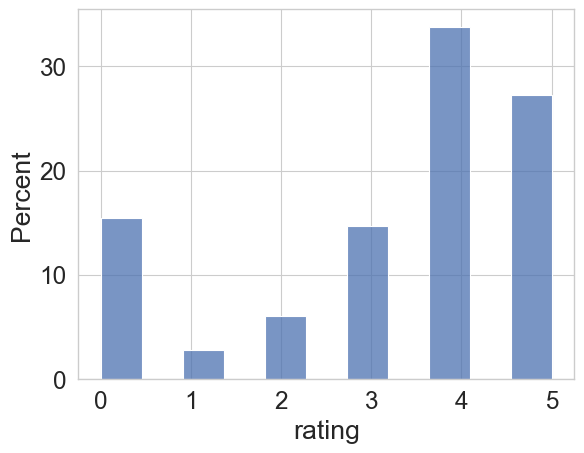

In [79]:
caption_ratings = annotations_df.merge(evaluations_df, left_on=['id'], right_on=['annotation_id'])[['annotation_id', 'text', 'familiarity', 'rating']]
plt.figure()
sns.histplot(data=caption_ratings['rating'], stat='percent')


No correlation between familiarity and rating

,familiarity,rating
familiarity,1.000000,0.095405
rating,0.095405,1.000000


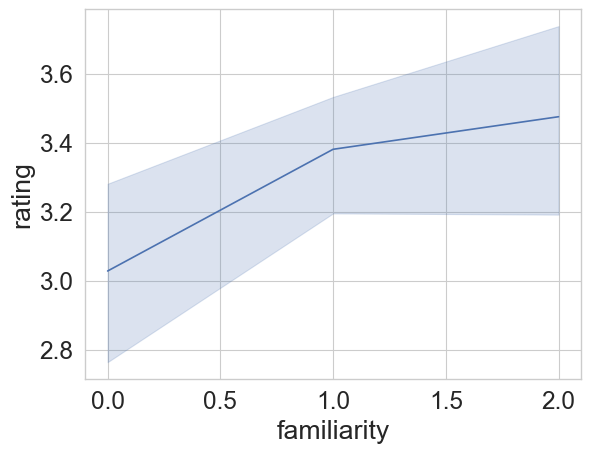

In [80]:
sns.lineplot(x=caption_ratings['familiarity'], y=caption_ratings['rating'])
caption_ratings[['familiarity', 'rating']].corr()


### Other

In [81]:
skippedtracks_df.groupby("track_id").count().sort_values("user_id", ascending=False).drop(["user_id", "timestamp"], axis=1)[:10]


,comments
track_id,
7259,3
1157362,3
1157358,2
945192,2
33324,2
5340,2
12303,2
357385,2
1009675,1


In [82]:
for task, df in [("annotation", annotations_df), ("evaluation", evaluations_df)]:
    print(f"Earliest timestamp {task}: ", min(df['timestamp']).date())
    print(f"Latest timestamp {task}: ", max(df['timestamp']).date())


Earliest timestamp annotation:  2022-11-25
Latest timestamp annotation:  2023-04-07
Earliest timestamp evaluation:  2022-11-25
Latest timestamp evaluation:  2023-04-12


In [83]:
users_no_english = users_display_active[users_display_active["english_level"] == "No"].index.tolist()
captions_no_en = annotations_df[annotations_df["user_id"].isin(users_no_english)]


In [84]:
captions_no_en["text"].values.tolist()


['This track starts with a man signing with a robotic register, before a rubbery, slightly sinister synth counters',
 'Electrónica positiva con secuencias de tempo animado  y algo de fantasía futurista en los sintetizadores, graves profundos y agudos brillantes']

In [85]:
sd = pd.read_csv("../data/song_describer.csv")
valid_sd = sd[sd["is_valid_subset"].fillna(False)]
# valid annotation ids
valid_annotation_ids = annotations_df[annotations_df.index.isin(valid_sd["caption_id"])]
users_with_valid_annotations = valid_annotation_ids["user_id"].nunique()


In [87]:
users_with_valid_annotations


114